### by Кулишенко Макар Андреевич

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

print(torch.__version__)

2.4.1+cu121


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall22/week01-pytorch_intro/notmnist.py
    !touch .setup_complete

# Task 1. Tensors (1 point)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

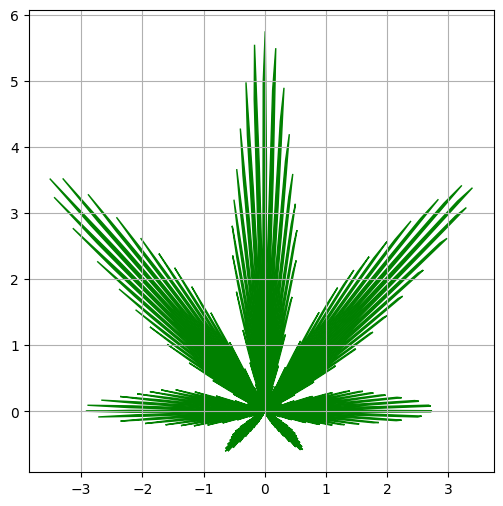

In [4]:
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(8 * theta)) * (1 + 0.1 * torch.cos(24 * theta)) * (0.9 + 0.5 * torch.cos(200 * theta)) * (1 + torch.sin(theta))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)


plt.figure(figsize=[6, 6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

# Task 2: Going deeper (6 points)

Your ultimate task here is to build your first neural network [almost] from scratch and pure PyTorch.

This time you will solve the same digit recognition problem, but at a larger scale

* 10 different letters
* 20k samples

We want you to build a network that __reaches at least 80% accuracy__ and has __at least 2 linear layers__ in it.

With 10 classes you need __categorical crossentropy__  (see [here](http://wiki.fast.ai/index.php/Log_Loss)) loss. You can write it any way you want, but we recommend to use log_softmax function from pytorch, since it is more numerically stable.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you nice score.

__Win conditions:__
* __Your model must be nonlinear,__ but not necessarily deep.
* __Train your model with your own SGD__ - which you will have to implement
* __For this task only, please do not use the contents of `torch.nn` and `torch.optim`.__ That's for the next task.
* __Do not use Conv layers__

**Bonus:** For the best score in group you get +1.5, 1.0, 0.5 point(1st. 2nd, 3rd places).

In [5]:
from notmnist import load_notmnist
X_train, y_train, X_val, y_val = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_val = X_train.reshape([-1, 784]), X_val.reshape([-1, 784])

Extracting ...
Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


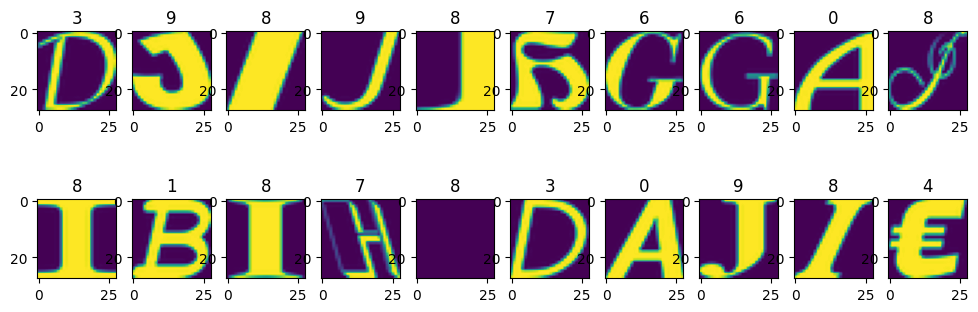

In [6]:
%matplotlib inline
plt.figure(figsize=[12, 4])
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14043, 784), (14043,), (4681, 784), (4681,))

In [8]:
classes = np.unique(y_train)
n_classes = len(classes)
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
torch.manual_seed(0)
np.random.seed(42)

Создадии нейронную сеть, которая будет содержать 3 линейный слоя и использовать ReLU в качестве функции активации.

In [32]:
class CustomNet:
    def __init__(self, hidden_size=256, in_size=28*28, num_classes=n_classes):
      self.hidden_size = hidden_size
      self.in_size = in_size
      self.num_classes = num_classes
      # Создадим 3 линейных слоя, веса будем генерировать из распределения Кайминга
      std_w = (2 / self.in_size) ** 0.5
      self.w1 = torch.randn(self.in_size, self.hidden_size * 2, device=DEVICE).normal_(0, std_w).requires_grad_(True)
      self.w2 = torch.randn(self.hidden_size * 2, self.hidden_size, device=DEVICE).normal_(0, std_w).requires_grad_(True)
      self.w3 = torch.randn(self.hidden_size, self.num_classes, device=DEVICE).normal_(0, std_w).requires_grad_(True)
      self.bias1 = torch.zeros(self.hidden_size * 2, device=DEVICE, requires_grad=True)
      self.bias2 = torch.zeros(self.hidden_size, device=DEVICE, requires_grad=True)
      self.bias3 = torch.zeros(self.num_classes, device=DEVICE, requires_grad=True)
      self.parameters = [self.w1, self.w2, self.w3, self.bias1, self.bias2, self.bias3]

    def get_parameters(self):
      return self.parameters

    def leaky_relu(self, tensor, alpha=0.01):
      return torch.where(tensor >= 0, tensor, alpha * tensor)

    def relu(self, tensor):
      return torch.maximum(tensor, torch.tensor(0.0, device=tensor.device))

    def forward(self, x):
      step1 = self.relu(x @ self.w1 + self.bias1)
      step2 = step1 @ self.w2 + self.bias2
      return step2 @ self.w3 + self.bias3


In [33]:
net = CustomNet()
out = net.forward(torch.randn(2, 28*28, device=DEVICE))
assert len(out.shape) == 2
assert out.shape[-1] == n_classes

Напишем свою функцию для вычисления кросс-энтропии:

In [34]:
import torch.nn.functional as F

def cross_entropy_loss(logits, target):
    N = logits.size(0)
    # Get the log probabilities
    log_probs = F.log_softmax(logits, dim=1)
    # Gather the log probabilities at the target indices
    log_probs_at_target = log_probs.gather(1, target.view(-1, 1))
    # Compute the negative log likelihood
    nll = -log_probs_at_target.sum()
    return nll / N

y_tmp = torch.tensor(y_train[:2], dtype=torch.int64, device=DEVICE)
cross_entropy_loss(out, y_tmp), torch.nn.CrossEntropyLoss()(out, y_tmp)

(tensor(2.9003, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.9003, device='cuda:0', grad_fn=<NllLossBackward0>))

Кастомизируем оптимизатор под Adam. Для этого будем изменять веса по принципу:
\begin{align}
v_{k+1} &= \beta_1 v_k + (1 - \beta_1) \nabla f(x_k) \\
G_{k+1} &= \beta_2 G_k + (1 - \beta_2) \left( \nabla f(x_k) \right)^2 \\
x_{k+1} &= x_k - \frac{\alpha \cdot v_{k+1}}{\sqrt{G_{k+1}} + \epsilon}
\end{align}

In [35]:
class CustomSGD:
    def __init__(self, model, lr=1e-4, epsilon=1e-8, beta1=0.9,beta2=0.999):
        self.model = model
        self.lr = lr
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.v = [torch.zeros_like(param) for param in self.model.get_parameters()]
        self.G = [torch.zeros_like(param) for param in self.model.get_parameters()]
        self.t = 0

    def step(self):
        self.t += 1
        with torch.no_grad():
            for param, v, G in zip(self.model.parameters, self.v, self.G):
                if param.grad is not None:
                    g = param.grad
                    v.mul_(self.beta1).add_((1 - self.beta1) * g)
                    G.mul_(self.beta2).add_((1 - self.beta2) * g**2)
                    param -= self.lr * v / (torch.sqrt(G) + self.epsilon)


    def zero_grad(self):
        for param in self.model.parameters:
            if param.grad is not None:
                param.grad = None


In [36]:
def iterate_minibatches(X, y, batch_size):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batch_size):
        ix = indices[start: start + batch_size]
        yield torch.from_numpy(X[ix]), torch.from_numpy(y[ix])

Добавим еще L2-регуляризацию, которая будет к текущему лоссу добавлять квадраты весов послое каждого шага градиентного спуска. Так мы сможем предотвратить переобучение модели

In [37]:
def train(net, optimizer, loss_fn, n_epoch=50, l2_coef=0.001):
    loss_history = []
    acc_history = []
    val_loss_history = []
    val_acc_history = []

    for i in range(n_epoch):
        # Training
        acc_batches = []
        loss_batches = []
        for x_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size=40):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            # Forward
            optimizer.zero_grad()
            out = net.forward(x_batch)
            loss = loss_fn(out, y_batch)

            # L2
            l2_loss = sum(torch.sum(param ** 2) for param in net.get_parameters())
            loss += l2_coef * l2_loss

            # Backward
            loss.backward()
            optimizer.step()

            # Accuracy
            acc_batches += (out.argmax(axis=1) == y_batch).detach().cpu().numpy().tolist()

            loss_batches.append(loss.detach().cpu().item())

        loss_history.append(np.mean(loss_batches))
        acc_history.append(np.mean(acc_batches))

        # Validating
        with torch.no_grad():
            acc_batches = []
            loss_batches = []
            for x_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size=40):
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                # Forward
                out = net.forward(x_batch)
                loss = loss_fn(out, y_batch)

                # L2
                l2_loss = sum(torch.sum(param ** 2) for param in net.get_parameters())
                loss += l2_coef * l2_loss

                # Accuracy
                acc_batches += (out.argmax(axis=1) == y_batch).cpu().numpy().tolist()
                loss_batches.append(loss.cpu().item())

            val_loss_history.append(np.mean(loss_batches))
            val_acc_history.append(np.mean(acc_batches))

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.set_xlabel("#epoch")
        ax1.set_ylabel("Loss")
        ax1.plot(loss_history, 'b', label='train loss')
        ax1.plot(val_loss_history, 'r', label='val loss')

        ax2.set_xlabel("#epoch")
        ax2.set_ylabel("Acc")
        ax2.plot(acc_history, 'b', label='train acc')
        ax2.plot(val_acc_history, 'r', label='val acc')
        plt.axhline(y=0.8, color='g', linestyle='--')

        plt.legend()
        plt.show()

    return max(val_acc_history)

Обучим нейросеть на тренировочных данных и проверим качество на валидации

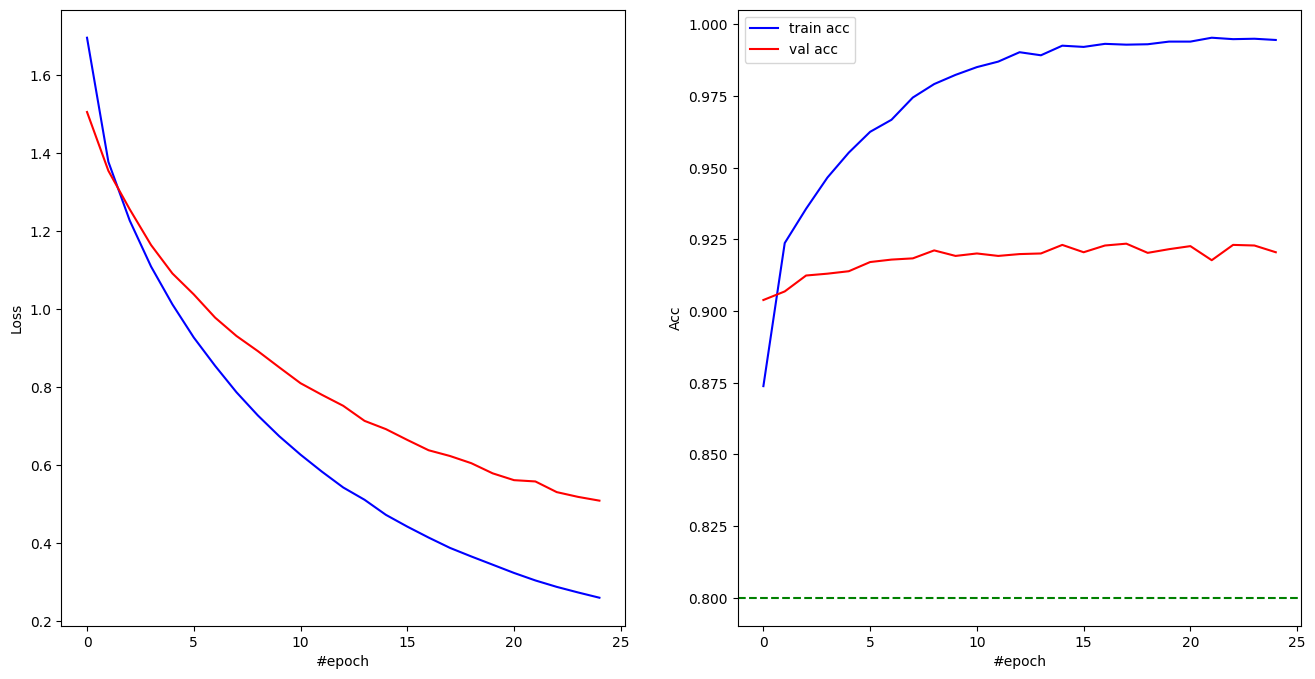

0.923520615253151

In [39]:
net = CustomNet()
opt = CustomSGD(net)
train(net, opt, cross_entropy_loss, 25)

Получили accuracy, равное 0.9235.

Какие гиперпараметры я подбирал?

- learning rate. Получилось, что наименьшее переобучение получается при lr = 1e-4
- n_epoch. При количестве эпох более 25 сеть получается переобученной: кривая лосса на валидации выходиьт на асимптоту и начинает расти.
- для параметров Adam я взял стандартные значения: при них получается самая высокая accuracy
- hidden_layer. Наилучшее значение accuracy достигается при размере слоя в 256.

Видим, что после 25 эпох кривая валидации начинает "выходить на асимптоту", а кривая трейна продолжает падать. Чтобы не допустить переобучение, есть смысл остановить обучение модели после 20 эпох.

### Hints:
  - You'll have to use matrix W(feature_id x class_id)
  - Softmax (exp over sum of exps) can be implemented manually or as `torch.softmax`
  - Probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
  - You need to train both layers, not just the output layer :)
  - 50 hidden neurons and a ReLU nonlinearity will do for a start. Many ways to improve.
  - In ideal case this totals to 2 `torch.matmul`'s, 1 softmax and 1 ReLU/sigmoid  
  - If anything seems wrong, try going through one step of training and printing everything you compute.
  - If you see NaNs midway through optimization, you can estimate $\log P(y \mid x)$ as `torch.log_softmax(last_linear_layer_outputs)`.

# Task 3. Overfitting (4 points)


Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
0. Fill the gaps in training loop and architectures.
1. Train a tiny __FC__ network.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

Train a network that achieves $\geq 0.885$ test accuracy. Again you should use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

__Please, write a small report describing your ideas, tries and achieved results in the end of this task.__

*Note*: in task 3 your goal is to make the network from task 2 less prone to overfitting. And then to train the network that achives $\geq 0.885$ test accuracy, so it can be different.

**Bonus:** For the best score in group you get +1.5, 1.0, 0.5 point(1st, 2nd, 3rd places).

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()

fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26421880/26421880 [00:01<00:00, 15978207.65it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 306492.77it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5513993.38it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6619336.91it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [ ]:
fmnist_dataset_train, fmnist_dataset_val = train_test_split(fmnist_dataset_train, train_size=50000)

In [ ]:
len(fmnist_dataset_train), len(fmnist_dataset_val), len(fmnist_dataset_test)

(50000, 10000, 10000)

In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

val_loader = torch.utils.data.DataLoader(fmnist_dataset_val,
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

torch.Size([128, 1, 28, 28])
torch.Size([128])


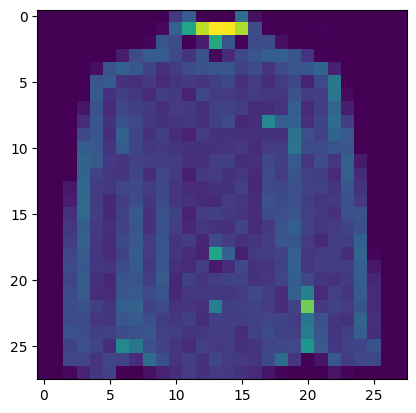

In [ ]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    break

plt.imshow(img[0, 0]);

In [ ]:
def train_val_loop(net, train_loader, val_loader, name, optimizer, criterion, n_epoch=20):
    loss_history = []
    acc_history = []
    val_loss_history = []
    val_acc_history = []

    for i in range(n_epoch):
        net.train()
        acc_batches=[]
        loss_batches=[]
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            # Forward
            loss = criterion(net.forward(x_batch), y_batch)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accuracy
            acc_batches += (net.forward(x_batch).argmax(axis=1) == y_batch).detach().cpu().numpy().tolist()

            loss_batches.append(loss.detach().cpu().item())

        loss_history.append(np.mean(loss_batches))
        acc_history.append(np.mean(acc_batches))

        # Validating
        net.eval()
        with torch.no_grad():
            acc_batches=[]
            loss_batches=[]
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)

                # Forward
                loss = criterion(net.forward(x_batch), y_batch)

                # Accuracy
                acc_batches += (net.forward(x_batch).argmax(axis=1) == y_batch).detach().cpu().numpy().tolist()
                loss_batches.append(loss.detach().cpu().item())

            val_loss_history.append(np.mean(loss_batches))
            val_acc_history.append(np.mean(acc_batches))



        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.set_xlabel("#epoch")
        ax1.set_ylabel("Loss")
        ax1.plot(loss_history, 'b', label='train loss')
        ax1.plot(val_loss_history, 'r', label='val loss')

        ax2.set_xlabel("#epoch")
        ax2.set_ylabel("Acc")
        ax2.plot(acc_history, 'b', label='train acc')
        ax2.plot(val_acc_history, 'r', label='val acc')
        plt.axhline(y=0.8, color='g', linestyle='--')

        plt.legend()
        plt.show()

def test_accuracy(model):
    model.eval()
    test_acc_batches = []
    with torch.no_grad():
        for X_test, Y_test in test_loader:
            X_test = X_test.to(DEVICE)
            Y_test = Y_test.to(DEVICE)
            out = model.forward(X_test)
            test_acc_batches += (out.argmax(axis=1) == Y_test).detach().cpu().numpy().tolist()
    print(f'Test accuracy {np.mean(test_acc_batches)}')

## Task 3.1 Tiny net
Train a tiny network just to validate correctness of train loop, net architecture, params.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.BatchNorm1d(200),
            nn.Dropout(0.5),
            nn.Linear(200, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
model = TinyNeuralNetwork()
out = model(torch.randn(2, 1, 28, 28))
assert len(out.shape) == 2
assert out.shape[-1] == 10

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(DEVICE), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 200]          20,200
       BatchNorm1d-5                  [-1, 200]             400
           Dropout-6                  [-1, 200]               0
            Linear-7                   [-1, 10]           2,010
Total params: 101,110
Trainable params: 101,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


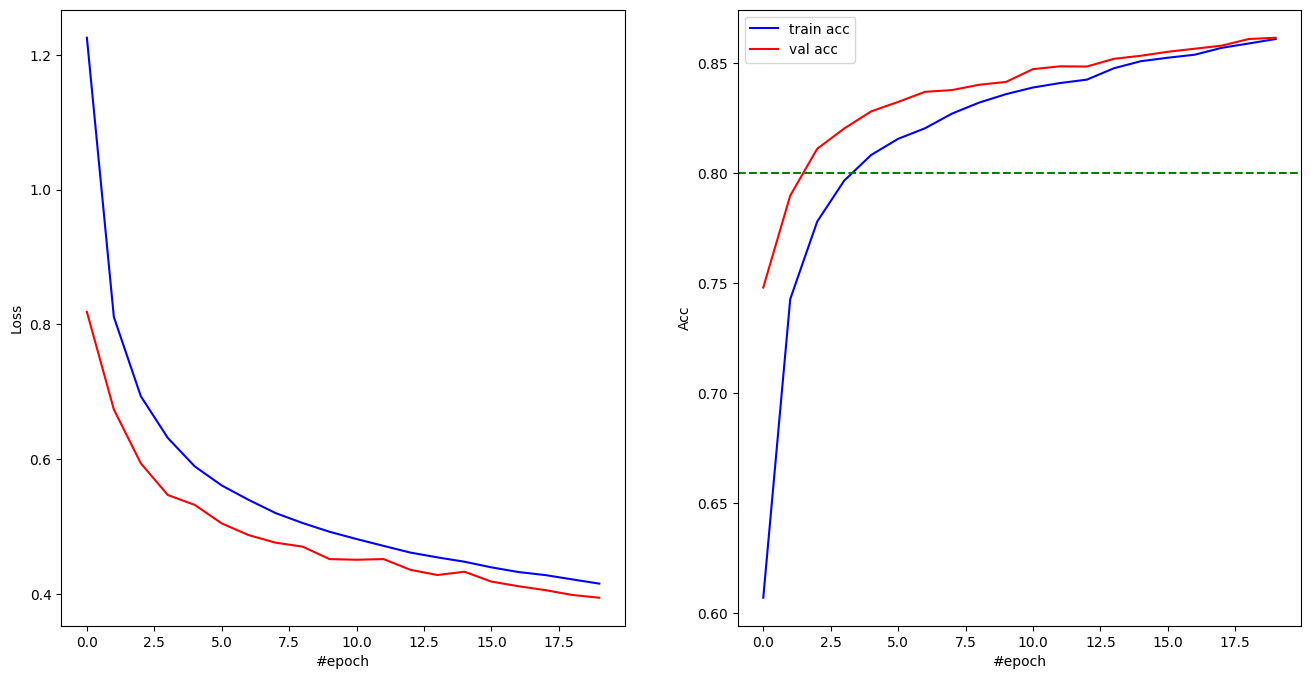

In [ ]:
tiny_model = TinyNeuralNetwork().to(DEVICE)
opt = torch.optim.SGD(tiny_model.parameters(), lr=1e-3)
loss_func = F.cross_entropy
n_epoch = 20
train_val_loop(tiny_model, train_loader=train_loader, val_loader=val_loader, name='tiny model', optimizer=opt, criterion=loss_func, n_epoch=n_epoch)

In [ ]:
test_accuracy(tiny_model)

Test accuracy 0.8472


## Task 3.2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

Для того, чтобы переобучить нейросеть, изменим:
- количество параметров (увеличим до 6 млн.)
- размер обучающей выборки (до 4500, чтобы модель смогла обучиться, но при этом запомнила всю выборку)
- количество эпох (увеличим до 50, чтобы модель прогнала всю выборку большее количество раз)
- функции активации (возьмем не сильно качественне сигмоиду и гипертангенс)

Количество линейных слоев оставим прежним, чтобы показать, что переобучить нейросеть можно и без увеличения числа слоев.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1000),
            nn.Sigmoid(),
            nn.Linear(1000, 2000),
            nn.Linear(2000, 2000),
            nn.Tanh(),
            nn.Linear(2000, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

Уменьшим размер обучающей выборки до 4500, чтобы вызвать переобучение

In [ ]:
fmnist_dataset_train_cut, _ = train_test_split(fmnist_dataset_train[:5000], train_size=4500)
train_cut_loader = torch.utils.data.DataLoader(fmnist_dataset_train_cut,
                                           batch_size=50,
                                           shuffle=True,
                                           num_workers=2)

model = OverfittingNeuralNetwork()
out = model(torch.randn(2, 1, 28, 28))
assert len(out.shape) == 2
assert out.shape[-1] == 10

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(DEVICE), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1000]         785,000
           Sigmoid-3                 [-1, 1000]               0
            Linear-4                 [-1, 2000]       2,002,000
            Linear-5                 [-1, 2000]       4,002,000
              Tanh-6                 [-1, 2000]               0
            Linear-7                   [-1, 10]          20,010
Total params: 6,809,010
Trainable params: 6,809,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 25.97
Estimated Total Size (MB): 26.04
----------------------------------------------------------------


Будем использовать оптимизатор Adam, чтобы сеть обучалась быстрее

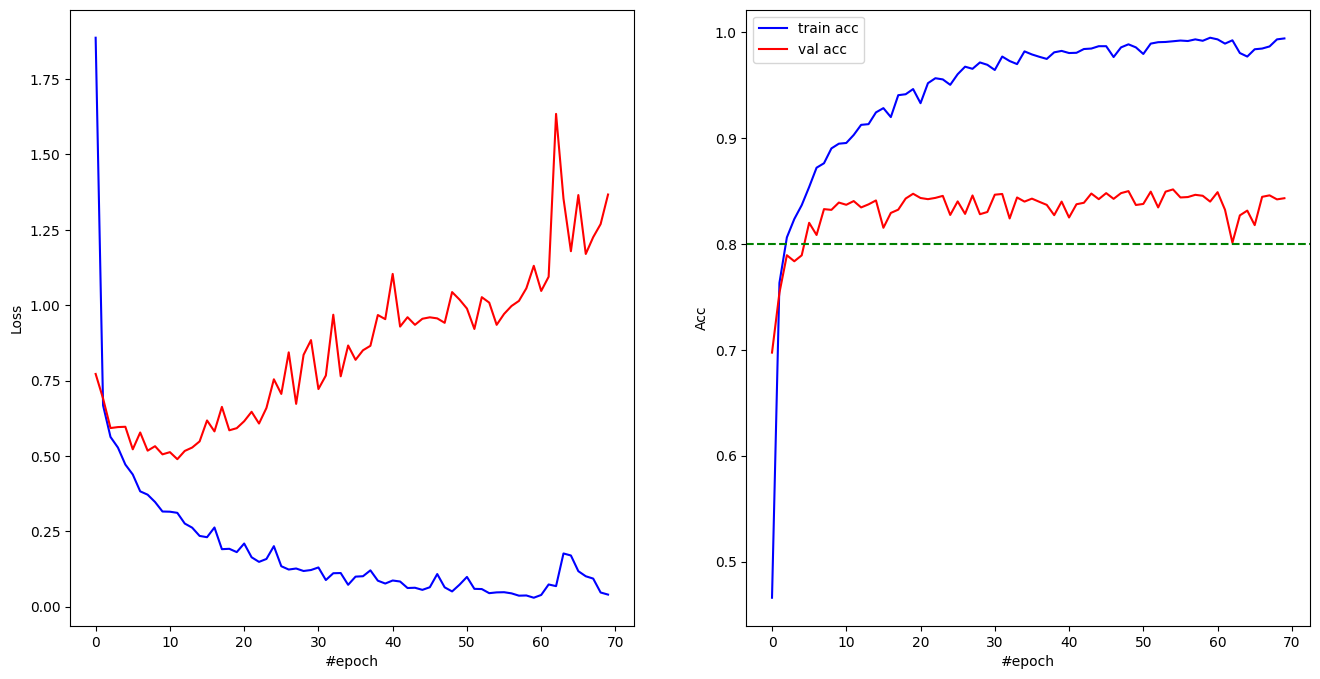

In [ ]:
overfit_model = OverfittingNeuralNetwork().to(DEVICE)
opt = torch.optim.Adam(overfit_model.parameters(), lr=1e-3)
loss_func = F.cross_entropy
n_epoch = 70

# Your experiments, come here
train_val_loop(overfit_model, train_loader=train_cut_loader, val_loader=val_loader, name='overfit model', optimizer=opt, criterion=loss_func, n_epoch=n_epoch)

In [ ]:
test_accuracy(overfit_model)

Test accuracy 0.8391


Мы видим, что на валидационной выборке кривая функции потерь сначала идет вниз,а затем взмывает вверх, при том, что ошибка на обучающей выборке все еще падает. Если посмотреть на accuracy, то переобученная сеть имеет более низкое значение данной метрики на тестовой выборке, что может говорить о том, что модель переобучилась

**Эксперименты**

В попытках переобучить нейросеть, я изменял такие гиперпараметры, как n_epoch, размер обучающей выборки и размер батча.

Наиболее сильно эффект переобучения заметен при следующих значениях гиперпараметров: n_epoch = 50, batch_size = 50, X_train содержит 4500 экземпляров.

При меньшем размере обучающей выборки модель очень плохо обучается, поэтому было установлено, что для демонстрации эффекта переобучения необходимо как минимум 4000 экземпляров.

При большом количество эпох модель обучается слишком долго, 50 - баланс между временем обучения и эффектом переобучения



## Task 3.3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

Добавим к нашей нейронной сети регуляризацию батчнормом, дропаут и изменим функции активации на ReLU и GELU. При этом оставим так же 4 линейных слоя, чтобы показать, что в моделях с одинаковой архитектурой можно избежать переобучение.

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, hidden_size=2 ** 8, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_size, hidden_size + 200),
            nn.GELU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_size + 200, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
model = FixedNeuralNetwork()
out = model(torch.randn(2, 1, 28, 28))
assert len(out.shape) == 2
assert out.shape[-1] == 10

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(DEVICE), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
              GELU-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 456]         117,192
              GELU-7                  [-1, 456]               0
           Dropout-8                  [-1, 456]               0
            Linear-9                  [-1, 256]         116,992
      BatchNorm1d-10                  [-1, 256]             512
             ReLU-11                  [-1, 256]               0
           Linear-12                   [-1, 10]           2,570
Total params: 438,738
Trainable params: 438,738
Non-trainable params: 0
-------------------------------

В качестве оптимизатора будем использовать AdamW. Он будет добавлять L2-регуляризацию.

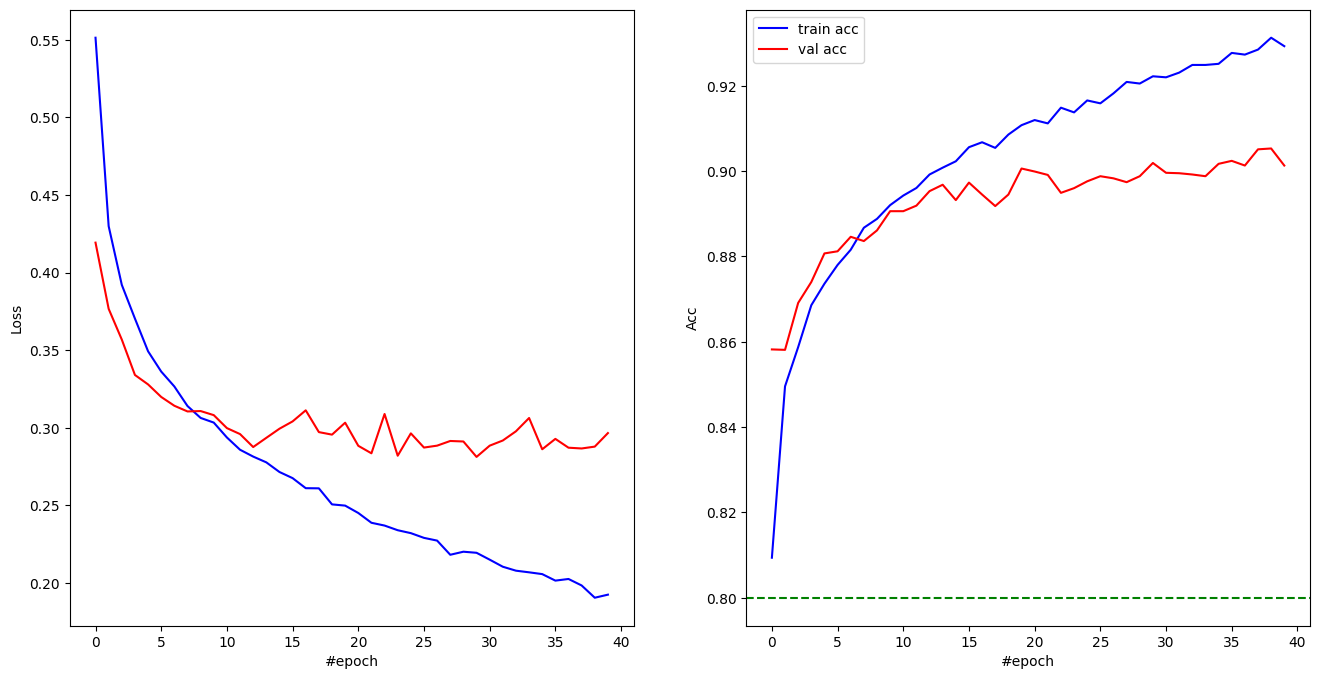

In [ ]:
fixed_model = FixedNeuralNetwork().to(DEVICE)
opt = torch.optim.AdamW(fixed_model.parameters(), lr=2*1e-3, weight_decay=1e-3)
loss_func = F.cross_entropy
n_epoch = 40

# Your experiments, come here
train_val_loop(fixed_model, train_loader=train_loader, val_loader=val_loader, name='fixed model', optimizer=opt, criterion=loss_func, n_epoch=n_epoch)

In [ ]:
test_accuracy(fixed_model)

Test accuracy 0.8972


Получилось accuracy = 0.8972 на тестовой выборке. Неплохой результат, особенно относительно accuracy переобученной сети. Если мы посмотрим на графиик обучения, то можно заметить, что после 35 эпох график кривой лосса валидации выходит на асимптоту и начинает отставать от графика трейна, что свидетельствует о начале переобучения. Поэтому оставим число эпох равным 40.

Попробуем добавить еще линейный слой:

In [ ]:
class FixedNeuralNetwork_1(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 200),
            nn.GELU(),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.Linear(100, 200),
            nn.Dropout(),
            nn.Linear(200, 100),
            nn.GELU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

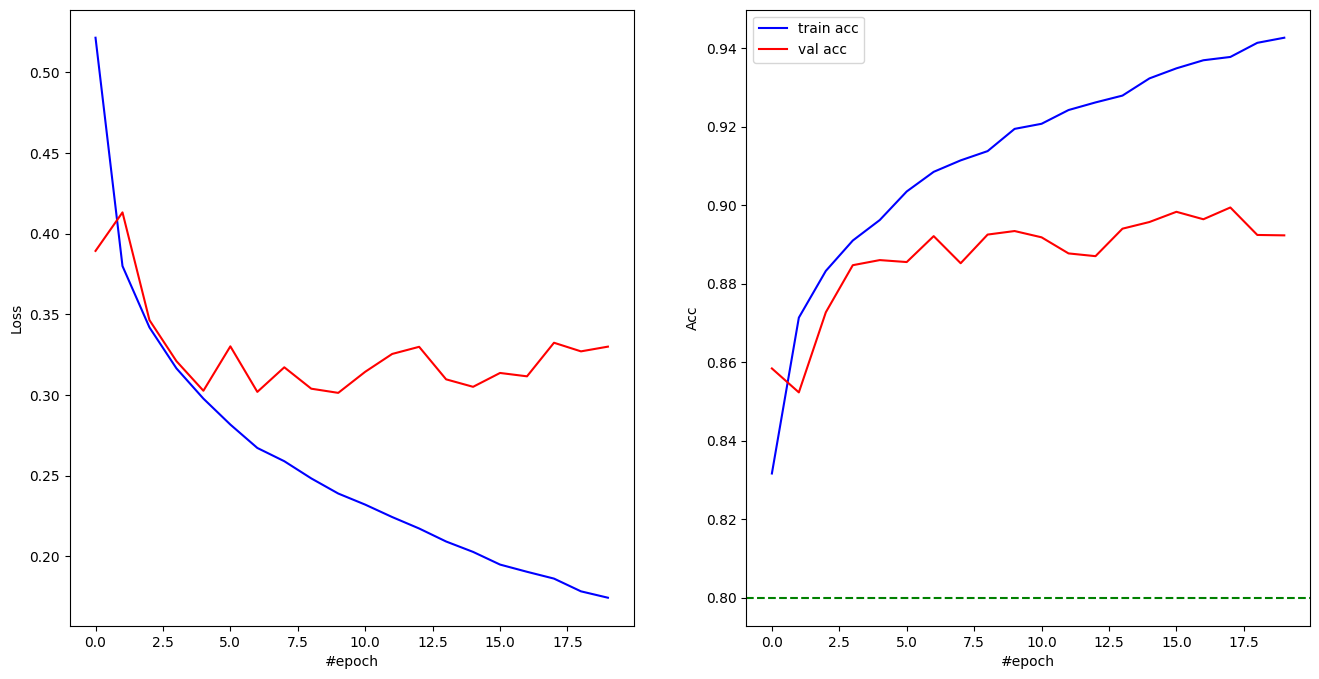

In [ ]:
fixed_model_1 = FixedNeuralNetwork_1().to(DEVICE)
opt_1 = torch.optim.AdamW(fixed_model_1.parameters(), lr=1e-3, weight_decay=1e-3)
loss_func_1 = F.cross_entropy
n_epoch = 20
# Your experiments, come here
train_val_loop(fixed_model_1, train_loader=train_loader, val_loader=val_loader, name='fixed model 1', optimizer=opt_1, criterion=loss_func_1, n_epoch=n_epoch)

In [ ]:
test_accuracy(fixed_model_1)

Test accuracy 0.8858


Видно, что хотя модель и выдает нужное accuracy уже после 20 эпох, при добавлении пятого линейного слоя модель начинает довольно быстро переобучаться.

Попробуем оставить 5 слоев, но уменьшить их размер:

In [ ]:
class FixedNeuralNetwork_2(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 100),
            nn.GELU(),
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.Linear(50, 75),
            nn.Dropout(),
            nn.Linear(75, 75),
            nn.GELU(),
            nn.BatchNorm1d(75),
            nn.Linear(75, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

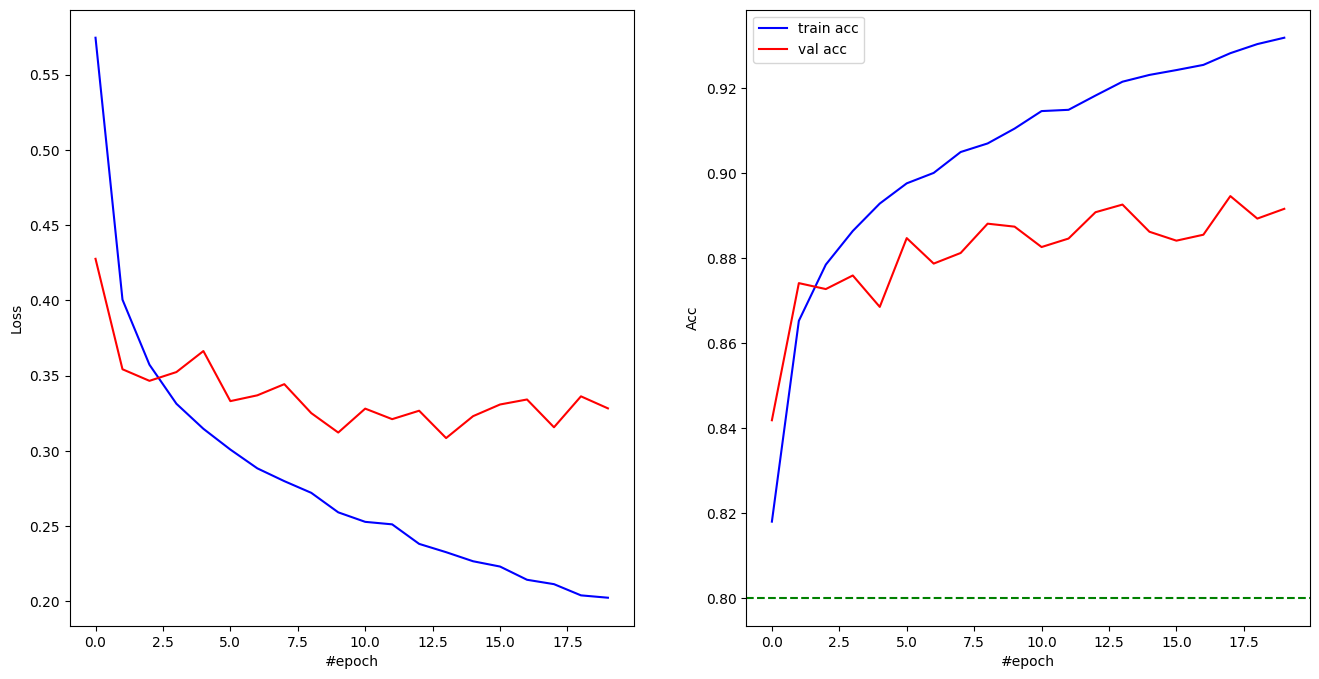

In [ ]:
fixed_model_2 = FixedNeuralNetwork_2().to(DEVICE)
opt_2 = torch.optim.AdamW(fixed_model_2.parameters(), lr=1e-3, weight_decay=1e-3)
loss_func_2 = F.cross_entropy
n_epoch = 20
# Your experiments, come here
train_val_loop(fixed_model_2, train_loader=train_loader, val_loader=val_loader, name='fixed model 1', optimizer=opt_2, criterion=loss_func_2, n_epoch=n_epoch)

Видно, что модель снова переобучается. Попробуем поменять оптимизатор на классический SGD.

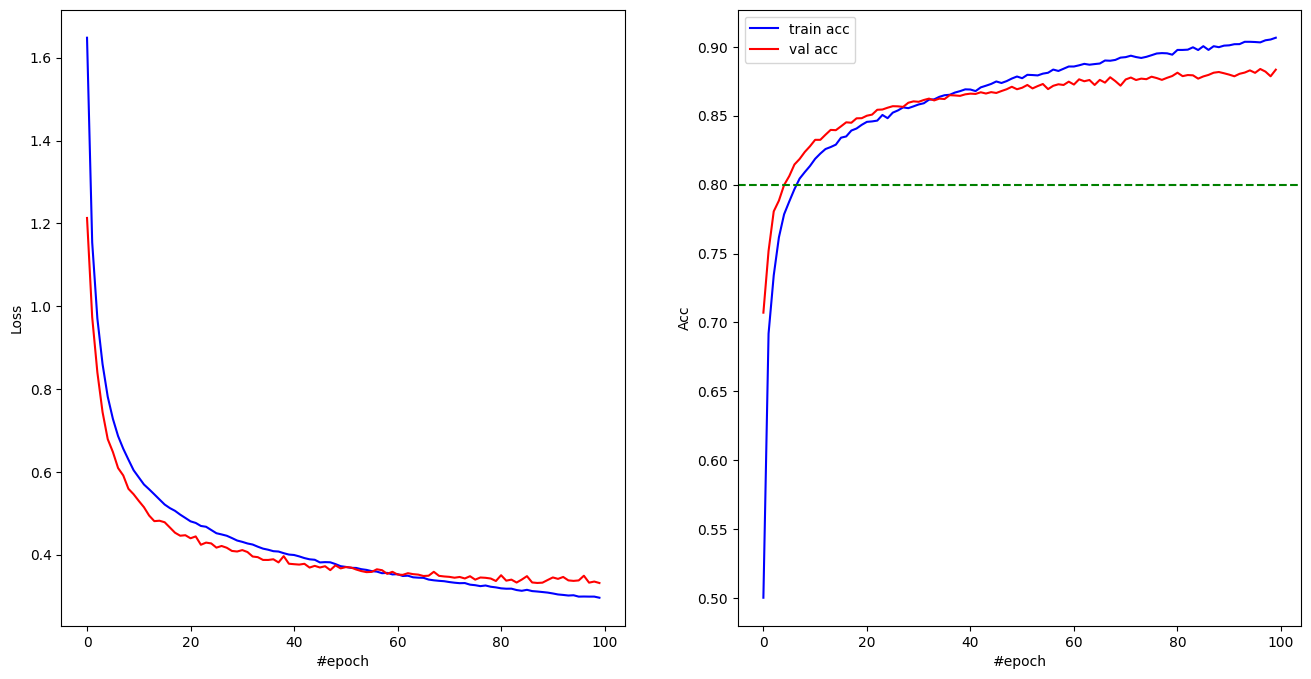

In [ ]:
fixed_model_2 = FixedNeuralNetwork_2().to(DEVICE)
opt_2 = torch.optim.SGD(fixed_model_2.parameters(), lr=1e-3)
loss_func_2 = F.cross_entropy
n_epoch = 100
# Your experiments, come here
train_val_loop(fixed_model_2, train_loader=train_loader, val_loader=val_loader, name='fixed model 1', optimizer=opt_2, criterion=loss_func_2, n_epoch=n_epoch)

In [ ]:
test_accuracy(fixed_model_2)

Test accuracy 0.8746


После 80 эпох видно, что модель начала переобучаться, при этом не выдала требуемую accuracy. Поэтому вернемся к самому первому варианту, который оказался наиболее эффективный.

### Conclusions:

При создании больших слоев с огромным количеством параметров и маленькой обучающей выборкой нейросеть может переобучиться, то есть с увеличением числа эпох ошибка на валидации резко возрастает, а на трейне все еще падает.

Как исправить переобучение?

1) Использовать линейные слои с меньшим числом параметров (например, если изображение имеет размер 28х28, 200 нейронов будет более чем достаточно - установлено экспериментальным путем)

2) Добавлять нелинейные функции активации, преимущественно ReLU или Leaky ReLU после линейных слоев

3) Использовать нормализацию по батчу - это позволяет сохранять вид (семейство) распределения данных на каждом слое сети, что означает более стабильное и корректное обучение нейросети, а также предотвращение взрыва градиента

4) Использовать dropout - позволяет избежать ситуации, когда вся информация сосредотачивается на конкретной группе нейронов, что вызывает переобучение. Dropout позволяет выключать определенные нейроны на каждом шаге обучения. Это позволяет сделать сеть более сбалансированной

5) Изменить оптимизатор - использование более простых оптимизаторов (например, SGD вместо Adam) может помочь снизить риск переобучения, но при этом не достичь требуемой точности

# Task 4. Your own nn layer. (4 points)

In [ ]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

### Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer.
You should implement it.

- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [ ]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        #it is important that we should multiply X @ W^T
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        return input @ self.W.T + self.b

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput @ self.W
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradW += gradOutput.T @ input
        self.gradb += np.sum(gradOutput, axis=0)

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

In [ ]:
def test_Linear():
    np.random.seed(42)
    torch.manual_seed(42)

    batch_size, n_in, n_out = 2, 3, 4
    for _ in range(100):
        # layers initialization
        torch_layer = torch.nn.Linear(n_in, n_out)
        custom_layer = Linear(n_in, n_out)
        custom_layer.W = torch_layer.weight.data.numpy()
        custom_layer.b = torch_layer.bias.data.numpy()

        layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
        next_layer_grad = np.random.uniform(-10, 10, (batch_size, n_out)).astype(np.float32)

        # 1. check layer output
        custom_layer_output = custom_layer.updateOutput(layer_input)
        layer_input_var = torch.from_numpy(layer_input).requires_grad_(True)
        torch_layer_output_var = torch_layer(layer_input_var)
        assert np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6)

        # 2. check layer input grad
        custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
        torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
        torch_layer_grad_var = layer_input_var.grad
        assert np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6)

        # 3. check layer parameters grad
        custom_layer.accGradParameters(layer_input, next_layer_grad)
        weight_grad = custom_layer.gradW
        bias_grad = custom_layer.gradb
        torch_weight_grad = torch_layer.weight.grad.data.numpy()
        torch_bias_grad = torch_layer.bias.grad.data.numpy()
        assert np.allclose(torch_weight_grad, weight_grad, atol=1e-6)
        assert np.allclose(torch_bias_grad, bias_grad, atol=1e-6)

In [ ]:
%%time
test_Linear()

CPU times: user 79 ms, sys: 882 µs, total: 79.8 ms
Wall time: 91.9 ms


Спасибо за домашку! Было прикольно!